# Modeling
1. [ElasticNet for yield prediction based on growing season weather](#section1)
2. [RNN time-series for predict growing seasonal weather](#section2)
3. [2020 National Corn Yield Prediction](#section3)

In [1]:
import pandas as pd
import numpy as np

# load data with known FIPS-level yield (some missing) at growing season
df_gs = pd.read_csv('data/weather_g_season.csv')
df_gs.fillna(0, inplace=True)
print(df_gs.shape)
# load target data with 
target_df = pd.read_csv('data/national_yld_cln.csv')
# load data with all season weather data as well as indices
df_pred = pd.read_csv('data/weather_all_season.csv')
df_pred.fillna(0, inplace=True)
print(df_pred.shape)

df_gs.head()

(11695, 26)
(34071, 22)


,Year,CRD,FIPS,Area,Yield,Total_yield,Mn,State_code,ppt_m,ppt_sum,...,tmean_median,tdif_m,tdif_median,tdif_max,tdif_min,RDI,SPI,PET,SPEI,PNP
0,2010,40,140,22000.0,93.8,2063600.0,4,1,0.092186,2.581206,...,64.878159,27.438870,28.873679,35.984079,11.641867,-1.469619,-0.743303,67.829868,-0.212651,0.907934
1,2010,40,140,22000.0,93.8,2063600.0,5,1,0.218002,5.886043,...,75.750555,21.400068,21.550048,28.771781,11.868437,-1.182696,-0.482563,125.774297,-0.265521,0.922967
2,2010,40,140,22000.0,93.8,2063600.0,6,1,0.127955,3.454786,...,82.427654,21.406183,21.553994,25.942136,16.029412,-1.151546,-0.166277,173.622551,-0.279187,0.959448
3,2010,40,140,22000.0,93.8,2063600.0,7,1,0.122960,3.442891,...,84.433309,20.639627,20.681452,24.000302,16.696620,-1.183056,-0.440580,190.856206,-0.765192,0.913384
4,2010,40,140,22000.0,93.8,2063600.0,8,1,0.118825,3.208287,...,83.826763,20.127898,20.974091,25.554035,11.240143,-1.114317,0.127317,177.288993,-0.580387,1.012049


<a id='section1'></a>
## Fit an ElasticNet Model Based on Growing Season
* pivot table from long to wide
* fit elasticnet model with 5-fold crossVal
* predict on national level yield and calculate accuracy

In [2]:
# preprocessing
df_ELN = df_gs.pivot_table(index=['Year', 'CRD', 'FIPS','Area','Yield','Total_yield','State_code'], 
                           columns=['Mn']).reset_index()
df_ELN.head()

Year CRD  FIPS       Area  Yield  Total_yield State_code        PET  \
Mn                                                                    4   
0   2010  10   110   127000.0  132.0   16764000.0          1  65.543294   
1   2010  10  1310    13800.0  113.4    1564920.0         13  68.560757   
2   2010  10  1710  2111000.0  170.1  359081100.0         17  61.216560   
3   2010  10  1810  1000000.0  164.5  164500000.0         18  61.680076   
4   2010  10  1910  1980000.0  184.7  365706000.0         19  59.747472   

                            ... tmean_median                                   \
Mn           5           6  ...            4          5          6          7   
0   111.491847  158.227597  ...    63.895154  72.600094  80.407162  81.836860   
1   117.693103  164.507182  ...    64.004156  72.494026  80.247550  81.856725   
2    93.449041  133.389533  ...    54.400199  59.898352  71.408736  75.561266   
3    93.111855  134.616544  ...    55.329140  60.157302  73.427448  75.252502   
4    85.280898  126.621425  ...    54.598207  60.211175  69.662564  73.348930   

                    tmin                                              
Mn          8          4          5          6          7          8  
0   82.698121  37.943095  46.667919  60.173894  61.110230  62.857805  
1   81.734689  37.831221  44.635106  61.073172  61.285739  61.391250  
2   74.875042  29.558627  34.148131  54.359674  55.136327  51.756197  
3   74.974569  30.496707  35.351764  49.610917  53.269561  51.926810  
4   74.895144  28.346277  30.802152  49.005702  59.023717  52.240249  

[5 rows x 97 columns]

In [0]:
# normalize to 1 and 0
def min_max_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

X = df_ELN.iloc[:, 7:]
y = min_max_norm(df_ELN['Yield'].values)
y

array([0.44087706, 0.36805012, 0.59005482, ..., 0.59005482, 0.40955364,
       0.29757244])

In [0]:
# model fitting

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

elasticnet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                          cv=5, verbose=0, n_jobs=-1, 
                          random_state=2020, selection='cyclic')
elasticnet.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049819373390640465, tolerance: 0.003822807508056161
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005423408382746686, tolerance: 0.003822807508056161
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056464998328316085, tolerance: 0.003822807508056161
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You 

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
             n_alphas=100, n_jobs=-1, normalize=False, positive=False,
             precompute='auto', random_state=2020, selection='cyclic',
             tol=0.0001, verbose=0)

In [0]:
# rescale back to original scale
def rescale_back(x, original_x):
    return (np.max(original_x) - np.min(original_x)) * x + np.min(original_x)

y_hat = rescale_back(elasticnet.predict(X), df_ELN['Yield'].values)

np.sqrt(mean_squared_error(df_ELN['Yield'].values, y_hat))

27.68197023764588

In [0]:
# predict on non-missing FIPS-level dataset

df_pred_gs = pd.merge(df_pred[df_pred['Mn'].isin([4,5,6,7,8])], df_gs[['Year', 'FIPS', 'Area']],
                      on = ['Year', 'FIPS'])
df_pred_ELN = df_pred_gs.pivot_table(index=['Year','FIPS','State_code', 'Area'], columns=['Mn']).reset_index()
df_pred_ELN['ELN_pred'] = rescale_back(elasticnet.predict(df_pred_ELN.iloc[:, 4:]), df_ELN['Yield'].values)
df_pred_ELN['Total_yield_pred'] = df_pred_ELN['ELN_pred'] * df_pred_ELN['Area']
df_national_pred = df_pred_ELN.groupby(['Year']).agg({'Area':'sum', 'Total_yield_pred':'sum'}).reset_index()
df_national_pred['ELN_pred'] = df_national_pred['Total_yield_pred'] / df_national_pred['Area'] 
df_national_pred = pd.merge(df_national_pred, target_df, on='Year')
df_national_pred

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,Year,Area,Total_yield_pred,ELN_pred,Value
0,2010,87173100.0,1.253098e+10,143.748257,152.6
1,2011,90902100.0,1.240146e+10,136.426559,146.8
2,2012,96171300.0,1.178909e+10,122.584299,123.1
3,2013,94045400.0,1.389857e+10,147.785784,158.1
4,2014,89506800.0,1.486642e+10,166.092665,171.0
5,2015,86753700.0,1.314562e+10,151.528092,168.4
6,2016,92770700.0,1.431118e+10,154.263957,174.6
7,2017,88715700.0,1.387298e+10,156.375744,176.6
8,2018,87386800.0,1.399404e+10,160.139115,176.4
9,2019,88210700.0,1.367046e+10,154.975077,168.0


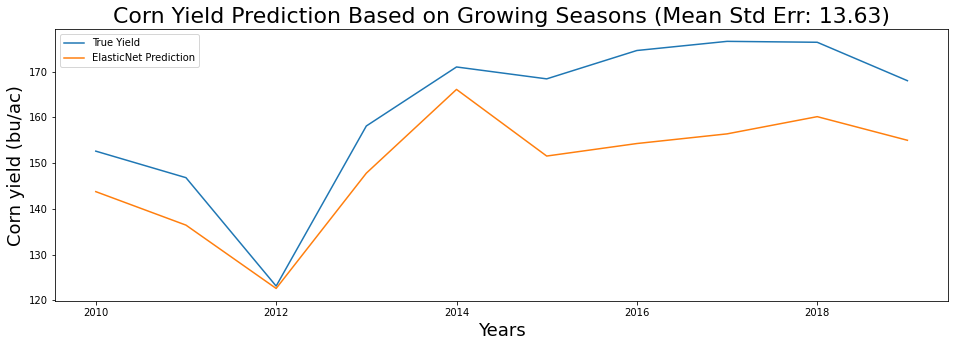

In [0]:
m_std_err = np.sqrt(mean_squared_error(df_national_pred['Value'].values, df_national_pred['ELN_pred']))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))

g = sns.lineplot(x='Year', y='Value', data=df_national_pred, label='True Yield')
g = sns.lineplot(x='Year', y='ELN_pred', data=df_national_pred, label='ElasticNet Prediction')
g.set_title(f"Corn Yield Prediction Based on Growing Seasons (Mean Std Err: {m_std_err:.2f})", fontsize=22)
g.set_xlabel("Years", fontsize=18)
g.set_ylabel('Corn yield (bu/ac)', fontsize=18)
    
plt.show()

<a id='section2'></a>
## Time-series model to predict growing season weather


In [0]:
from tensorflow.keras.layers import LSTM, Flatten, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

# normalize data
df_norm = df_pred
df_norm.iloc[:,4:] = df_pred.iloc[:,4:].apply(min_max_norm, axis=0)
df_norm

,Year,Mn,FIPS,State_code,ppt_m,ppt_sum,ppt_max,ppt_min,ppt_median,tmax,tmin,tmean,tmean_median,tdif_m,tdif_median,tdif_max,tdif_min,RDI,SPI,PET,SPEI,PNP
0,2010,1,110,1,0.219823,0.190513,0.173869,0.000000,0.000000,0.474922,0.446713,0.418833,0.409948,0.362115,0.375403,0.435803,0.148312,0.499987,0.500000,0.002531,0.500000,0.000000
1,2010,2,110,1,0.140700,0.117250,0.173226,0.000000,0.000213,0.542076,0.520154,0.431505,0.435913,0.287017,0.265672,0.422274,0.120320,0.499987,0.500000,0.005024,0.500000,0.000000
2,2010,3,110,1,0.158777,0.153485,0.092774,0.000000,0.000482,0.637660,0.555056,0.565264,0.581773,0.444284,0.507221,0.443169,0.097441,0.499987,0.500000,0.083532,0.500000,0.000000
3,2010,4,110,1,0.070781,0.068422,0.125064,0.000000,0.000000,0.720394,0.677334,0.700692,0.718692,0.602338,0.630821,0.440824,0.255097,0.117378,0.349898,0.239598,0.393341,0.186201
4,2010,5,110,1,0.222818,0.222818,0.260075,0.000000,0.051919,0.772019,0.751802,0.788614,0.806079,0.397383,0.431352,0.359925,0.221900,0.209251,0.457043,0.407567,0.456628,0.200032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34066,2019,11,5650,56,0.051836,0.048380,0.056704,0.000000,0.005478,0.561073,0.316436,0.399498,0.413584,0.521909,0.562515,0.681239,0.154595,0.888837,0.637334,0.002405,0.690010,0.299214
34067,2019,12,5650,56,0.017402,0.016822,0.017208,0.000000,0.000492,0.388095,0.393951,0.371779,0.390140,0.376418,0.412139,0.393089,0.244723,0.853996,0.520865,0.000000,0.578777,0.216753
34068,2020,1,5650,56,0.005006,0.004840,0.004900,0.000000,0.000111,0.354570,0.401574,0.379872,0.381829,0.463565,0.486627,0.395800,0.352777,0.751862,0.538608,0.000000,0.673526,0.228208
34069,2020,2,5650,56,0.015783,0.014205,0.014733,0.000001,0.001026,0.511738,0.291494,0.337767,0.334820,0.507077,0.458560,0.565586,0.267997,0.888973,0.631940,0.000000,0.645337,0.270919


In [0]:
seq_len = 12 # 12 months as predictors

# create input sequence
input_sequences = []
target = []

for fips in df_norm['FIPS'].unique():
    df_tmp = df_norm[df_norm['FIPS'] == fips].sort_values(['Year','Mn'])

    for i in range(seq_len+1, df_tmp.shape[0]):
        input_sequences.append(df_tmp.iloc[(i - seq_len - 1):(i-1), 4:].values)
        target.append(df_tmp.iloc[(i-1):(i), 4:].values)

input_sequences = np.array(input_sequences)
target = np.array(target)

print(input_sequences.shape)
print(target.shape)

(30470, 12, 18)
(30470, 1, 18)


In [0]:
target = target.reshape(-1, 18)
print(target.shape)

(30470, 18)


In [0]:
model = Sequential()
model.add(LSTM(32, input_shape=(seq_len, 18))) # 12 time steps and 18 features
model.add(Dropout(rate=0.2))
model.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.01),
                bias_regularizer=l1(0.01)))
model.add(Dense(18, activation='relu'))
# Pick an optimizer
adam = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6528      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              33000     
_________________________________________________________________
dense_1 (Dense)              (None, 18)                18018     
Total params: 57,546
Trainable params: 57,546
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
 history = model.fit(input_sequences, target, epochs=50, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 30470 samples
Epoch 1/50
30470/30470 [==============================] - 17s 560us/sample - loss: 0.0349 - mean_squared_error: 0.0159
Epoch 2/50
30470/30470 [==============================] - 17s 550us/sample - loss: 0.0232 - mean_squared_error: 0.0087
Epoch 3/50
30470/30470 [==============================] - 16s 538us/sample - loss: 0.0225 - mean_squared_error: 0.0082
Epoch 4/50
30470/30470 [==============================] - 16s 537us/sample - loss: 0.0225 - mean_squared_error: 0.0080
Epoch 5/50
30470/30470 [==============================] - 16s 534us/sample - loss: 0.0224 - mean_squared_error: 0.0079
Epoch 6/50
30470/30470 [==============================] - 16s 533us/sample - loss: 0.0223 - mean_squared_error: 0.0077
Epoch 7/50
30470/30470 [==============================] - 16s 521us/sample - loss: 0.0225 - mean_squared_error: 0.0077
Epoch 8/50
30470/30470 [==========================

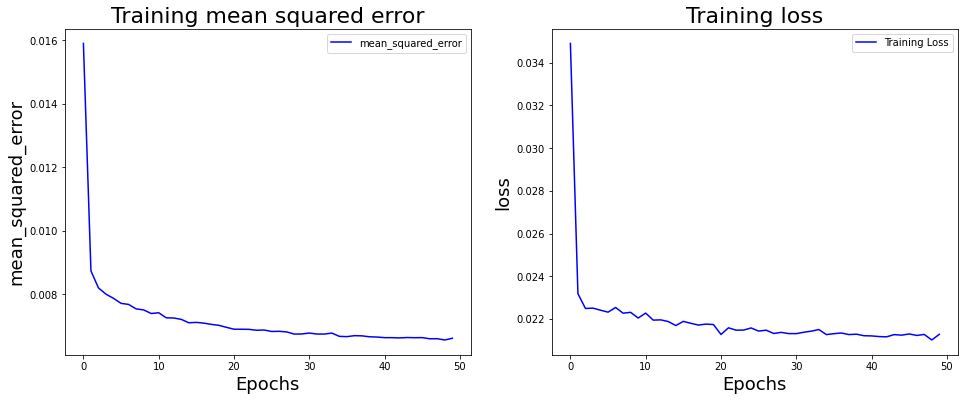

In [0]:
import matplotlib.pyplot as plt

acc = history.history['mean_squared_error']
loss = history.history['loss']

epochs = range(len(acc))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='mean_squared_error')
plt.title('Training mean squared error', fontsize=22)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('mean_squared_error', fontsize=18)
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss', fontsize=22)
plt.ylabel('loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend()

plt.show()

In [22]:
# predict til 2020.08
weather_predict = pd.DataFrame()
  
for fips in df_pred['FIPS'].unique():
    # get data from 2019.4 to 2020.3 for each FIPS
    df_tmp = df_pred[df_pred['FIPS'] == fips].sort_values(['Year','Mn']).iloc[-12:,:]
    state_code = df_tmp['State_code'].unique()[0]
    last_month = df_tmp['Mn'].values[-1]
    pred_len = 8 - last_month

    # predict for 2020.4 to 2020.8
    y_hat = []
    tmp_x = df_tmp.iloc[:,4:].values.reshape(-1,12,18)
    for i in range(pred_len):
        tmp_y = model.predict(tmp_x, verbose=0)
        y_hat.append(tmp_y.reshape(18))
        # add prediction to time-series
        tmp_x = np.concatenate((tmp_x.reshape(12,18), tmp_y), axis=0)
        # remove the earliest month
        tmp_x = tmp_x[1:,:].reshape(-1,12,18)
    
    df1 = pd.DataFrame({'Year': [2020] * pred_len,
                        'Mn': np.arange(last_month+1, 9),
                        'FIPS': [fips] * pred_len,
                        'State_code': [state_code] * pred_len})
    df2 = pd.DataFrame(np.array(y_hat), columns=df_tmp.columns[4:])
    df3 = pd.concat((df1, df2), axis=1)
    weather_predict = pd.concat((weather_predict,df3))
    
weather_predict

,Year,Mn,FIPS,State_code,ppt_m,ppt_sum,ppt_max,ppt_min,ppt_median,tmax,tmin,tmean,tmean_median,tdif_m,tdif_median,tdif_max,tdif_min,RDI,SPI,PET,SPEI,PNP
0,2020,4,110,1,0.146449,0.131869,0.099933,0.0,0.0,0.906811,0.982486,0.973226,0.980479,0.443165,0.455591,0.284369,0.433993,0.097096,0.847796,0.756851,0.861315,0.382992
1,2020,5,110,1,0.145834,0.128108,0.078367,0.0,0.0,0.969459,1.140674,1.120713,1.131143,0.405775,0.403621,0.201430,0.518389,0.090787,0.848093,0.994606,0.846661,0.367518
2,2020,6,110,1,0.102788,0.090925,0.062372,0.0,0.0,0.987710,1.089395,1.094389,1.107271,0.506403,0.503014,0.288576,0.574139,0.301164,0.488799,0.938179,0.468222,0.201402
3,2020,7,110,1,0.145414,0.133176,0.088996,0.0,0.0,1.005867,1.179575,1.169828,1.180894,0.388165,0.387268,0.173124,0.517035,0.000000,0.475163,1.049743,0.460150,0.186048
4,2020,8,110,1,0.144064,0.132944,0.101445,0.0,0.0,0.943292,1.051956,1.051239,1.060431,0.411515,0.417771,0.241495,0.440544,0.204478,0.425450,0.852329,0.412897,0.171499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020,4,5650,56,0.000000,0.000000,0.000000,0.0,0.0,0.778173,0.660738,0.701122,0.706999,0.738092,0.759637,0.562630,0.456299,0.000000,0.413491,0.373556,0.408900,0.208741
1,2020,5,5650,56,0.000000,0.000000,0.000000,0.0,0.0,0.878784,0.790746,0.856502,0.868937,0.757608,0.758660,0.524402,0.544200,0.000000,0.042299,0.563425,0.041807,0.028904
2,2020,6,5650,56,0.078888,0.070312,0.058522,0.0,0.0,0.895730,0.918526,0.935415,0.946862,0.538570,0.546210,0.363625,0.455668,0.263546,0.301222,0.681905,0.288119,0.129663
3,2020,7,5650,56,0.008504,0.003647,0.008093,0.0,0.0,0.896090,0.862593,0.901240,0.913040,0.672737,0.678653,0.455930,0.532990,0.083477,0.254244,0.628636,0.241923,0.113519


In [27]:
# if assume 2020 planted area is the average of previous years
fips_area = df_gs[['FIPS', 'Area']].groupby(['FIPS'])['Area'].mean().reset_index()
fips_area.head()

,FIPS,Area
0,110,136700.0
1,120,53640.0
2,130,20570.0
3,140,27260.0
4,150,17770.0


In [35]:
df_pred_gs = pd.merge(weather_predict, fips_area, on = 'FIPS')

df_pred_ELN = df_pred_gs.pivot_table(index=['Year','FIPS','State_code', 'Area'], columns=['Mn']).reset_index()
df_pred_ELN['ELN_pred'] = rescale_back(elasticnet.predict(df_pred_ELN.iloc[:, 4:]), df_ELN['Yield'].values)
df_pred_ELN['Total_yield_pred'] = df_pred_ELN['ELN_pred'] * df_pred_ELN['Area']
df_pred_ELN

Year  FIPS State_code  ...      tmin    ELN_pred Total_yield_pred
Mn                          ...         8                             
0    2020   110          1  ...  1.051956  149.404142     2.042355e+07
1    2020   120          1  ...  1.051016  149.379494     8.012716e+06
2    2020   130          1  ...  0.964909  151.725168     3.120987e+06
3    2020   140          1  ...  0.930841  151.492804     4.129694e+06
4    2020   150          1  ...  0.924183  151.391842     2.690233e+06
..    ...   ...        ...  ...       ...         ...              ...
257  2020  5580         55  ...  0.912529  150.883983     1.248716e+08
258  2020  5590         55  ...  0.901365  150.145668     3.679320e+07
259  2020  5610         56  ...  0.830317  148.087770     3.696271e+06
260  2020  5620         56  ...  0.747614  147.080521     4.559496e+05
261  2020  5650         56  ...  0.863937  149.171024     9.973148e+06

[262 rows x 96 columns]

<a id='section3'></a>
## 2020 National Corn Yield Prediction

In [37]:
print(f"The prediction for 2020 corn yield is {df_pred_ELN['Total_yield_pred'].sum() / df_pred_ELN['Area'].sum()}")

The prediction for 2020 corn yield is 151.2106689823216


In [0]:
# save data for the final prediction
weather_pred.to_csv('data/weather_2020.csv', index=False)

# save both model
model.save('rnn_weather_lstm.h5')

import pickle
pickle.dump(elasticnet, open('eln_yield.sav', 'wb'))